# Đọc các file JSON và chuyển thành dataframe

In [1]:
import pandas as pd
import numpy as np
import os
import json
from typing import List
from tqdm import tqdm
import re

## Tìm ra các file JSON trong thư mục

In [2]:
def list_file_types(directory: str, file_extension: str) -> List[str]:
    """ List all files with a specific extension in a directory.

    Args:
        directory (str): Directory path.
        file_extension (str): File extension.

    Returns:
        List[str]: List of file paths.
    """

    file_list: List[str] = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(file_extension):
                file_list.append(os.path.join(root, file))
    return file_list

In [3]:
json_files = list_file_types("food_location", ".json")
print(f"Number of JSON files found: {len(json_files)}")
# print(json_files[:5])

Number of JSON files found: 14252


## Đọc mỗi file JSON và chuyển thành dataframe

In [4]:
# Read each JSON file, extract the fields, and store the data in a list
# The data will be used to create a DataFrame

# Valid data
data: List[dict] = []
# Files don't start with "{"
files_not_start_with_curly_brace: List[str] = []
# Files don't end with "}"
files_not_end_with_curly_brace: List[str] = []
# Files with "no speech"
files_no_speech: List[str] = []
# General errors
error_files: List[str] = []

for json_file in tqdm(json_files):
    with open(json_file, 'r') as f:
        # Remove redundant newlines and spaces
        json_text: str = re.sub(r'\n+', ' ', f.read()).strip()
        # Replace `None` with `null`
        json_text = json_text.replace("None", "null")

        # Find the first occurrence of "{"
        start_index: int = json_text.find("{")
        if start_index > 0:
            # Remove any text before the first "{"
            json_text = json_text[start_index:]

        # Check if the file starts with "{"
        if not json_text.startswith("{"):
            # print(f"File does not start with curly brace: {json_file}")
            files_not_start_with_curly_brace.append(json_file)
            continue

        # Check if the file ends with "}"
        if not json_text.endswith("}"):
            # print(f"File does not end with curly brace: {json_file}")
            files_not_end_with_curly_brace.append(json_file)
            continue

        try:
            # Load the JSON data from the file
            json_data: dict = json.loads(json_text)

            # Extract the fields from the JSON data
            foods: List[str] = json_data.get("foods")

            city: str = json_data.get("city")
            if city == "None":
                city = None

            district: str = json_data.get("district")
            if district == "None":
                district = None

            # Append the data to the list
            # Lowercase all the text fields
            data.append({
                "video.id": os.path.basename(json_file).replace(".json", "").strip(),
                "foods": [food.lower().strip() for food in foods] if foods else None,
                "city": city.lower().strip() if city else None,
                "district": district.lower().strip() if district else None,
            })
        except Exception as e:
            # print(f"Error processing file {json_file}: {e}")
            error_files.append(json_file)

# Make sure the data is loaded correctly
print(f"Number of records loaded: {len(data)}")  # 1382
assert len(data) == len(json_files) - len(error_files) - \
    len(files_not_start_with_curly_brace) - \
    len(files_not_end_with_curly_brace) - len(files_no_speech)

100%|██████████| 14252/14252 [00:27<00:00, 514.31it/s]

Number of records loaded: 14252


Đảm bảo không có file nào gặp lỗi mà ta không kiểm soát được

In [5]:
# assert len(error_files) == 0
len(error_files), error_files

(0, [])

Các file không có giọng nói

In [6]:
len(files_no_speech)#, files_no_speech

0

Các file không bắt đầu bằng "{"

In [7]:
len(files_not_start_with_curly_brace)#, files_not_start_with_curly_brace

0

Các file không kết thúc bằng "}"

In [8]:
len(files_not_end_with_curly_brace), files_not_end_with_curly_brace

(0, [])

Lưu id của các file gặp lỗi

In [9]:
# error_files = []
# for file in files_not_start_with_curly_brace:
#     error_files.append(os.path.basename(file).replace(".json", ""))
# for file in files_not_end_with_curly_brace:
#     error_files.append(os.path.basename(file).replace(".json", ""))

# # Save the id data to a text file
# with open("../data/error/error_files.txt", 'w') as f:
#     for item in error_files:
#         f.write("%s\n" % item)

## Chuyển các file JSON thành dataframe

In [10]:
# Convert the list of dictionaries to a DataFrame
food_location_df = pd.DataFrame(data)
food_location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14252 entries, 0 to 14251
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   video.id  14252 non-null  object
 1   foods     13526 non-null  object
 2   city      4430 non-null   object
 3   district  2374 non-null   object
dtypes: object(4)
memory usage: 445.5+ KB


## Thống kê số lượng món ăn xuất hiện trong các file JSON

Các món ăn xuất hiện nhiều nhất trong tất cả các tuần

In [11]:
food_location_df["foods"].explode().value_counts().head(20)

foods
cơm           545
tôm           272
xúc xích      268
bánh mì       257
trà sữa       231
mì cay        215
thịt nướng    192
gà rán        185
mì            177
thịt bò       171
chân gà       165
bún           164
lẩu           163
kim chi       161
chả cá        155
mực           146
lạp xưởng     142
kem           140
trứng         135
xoài          135
Name: count, dtype: int64

## Lưu dữ liệu sau khi tổng hợp xuống 1 file Parquet

In [12]:
# Save to parquet file
food_location_df.to_parquet("./food_location_data.parquet", index=False)
del food_location_df

# Tạo một file dữ liệu hoàn chỉnh để chuẩn bị cho các bước phân tích tiếp theo


## Đọc file Parquet chứa dữ liệu về món ăn và địa điểm

In [13]:
food_location_df = pd.read_parquet("./food_location_data.parquet")
food_location_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14252 entries, 0 to 14251
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   video.id  14252 non-null  object
 1   foods     13526 non-null  object
 2   city      4430 non-null   object
 3   district  2374 non-null   object
dtypes: object(4)
memory usage: 445.5+ KB


## Đọc file Parquet chứa đầy đủ dữ liệu về top 20% video theo mỗi tuần

In [14]:
weekly_video_df = pd.read_parquet(
    "./top_20_percent_weekly_videos_transcripts.parquet")
weekly_video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14252 entries, 0 to 14251
Data columns (total 61 columns):
 #   Column                           Non-Null Count  Dtype                           
---  ------                           --------------  -----                           
 0   CategoryType                     14252 non-null  object                          
 1   author.downloadSetting           14252 non-null  object                          
 2   author.duetSetting               14252 non-null  object                          
 3   author.id                        14252 non-null  object                          
 4   author.nickname                  14252 non-null  object                          
 5   author.openFavorite              14252 non-null  object                          
 6   author.secUid                    14252 non-null  object                          
 7   author.signature                 14252 non-null  object                          
 8   author.stitchSet

## Merge các dataframe lại với nhau dựa trên `video.id`


In [15]:
# Merge the weekly video DataFrame with the food location DataFrame
# using left join to keep all video data
final_weekly_video_df = pd.merge(
    left=weekly_video_df, right=food_location_df,
    on="video.id", how="left"
)
final_weekly_video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14252 entries, 0 to 14251
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype                           
---  ------                           --------------  -----                           
 0   CategoryType                     14252 non-null  object                          
 1   author.downloadSetting           14252 non-null  object                          
 2   author.duetSetting               14252 non-null  object                          
 3   author.id                        14252 non-null  object                          
 4   author.nickname                  14252 non-null  object                          
 5   author.openFavorite              14252 non-null  object                          
 6   author.secUid                    14252 non-null  object                          
 7   author.signature                 14252 non-null  object                          
 8   author.stitchSet

## Phân tích số lượng món ăn theo từng tuần và địa điểm


,year_week,total_videos,videos_with_food,videos_with_city,videos_with_district,food_percentage,city_percentage,district_percentage
0,Y2023_W47,100,94,50,32,94.00,50.00,32.00
1,Y2023_W48,183,177,72,35,96.72,39.34,19.13
2,Y2023_W49,185,176,71,41,95.14,38.38,22.16
3,Y2023_W50,189,181,69,42,95.77,36.51,22.22
4,Y2023_W51,190,183,78,35,96.32,41.05,18.42
...,...,...,...,...,...,...,...,...
65,Y2025_W08,221,214,67,35,96.83,30.32,15.84
66,Y2025_W09,231,222,58,35,96.10,25.11,15.15
67,Y2025_W10,242,233,74,37,96.28,30.58,15.29
68,Y2025_W11,238,228,72,48,95.80,30.25,20.17


Top 20 foods across all weeks:


Series([], Name: count, dtype: int64)


Top 10 cities across all weeks:


city
hà nội                   1235
sài gòn                   888
hồ chí minh               514
hải phòng                 113
không có thông tin         98
vũng tàu                   93
đà lạt                     92
thành phố hồ chí minh      74
cần thơ                    68
an giang                   54
Name: count, dtype: int64


Top 10 districts across all weeks:


district
đống đa         143
quận 1          120
hoàn kiếm       109
bình thạnh      109
hai bà trưng    101
quận 5           92
cầu giấy         88
quận 7           86
gò vấp           83
quận 10          75
Name: count, dtype: int64

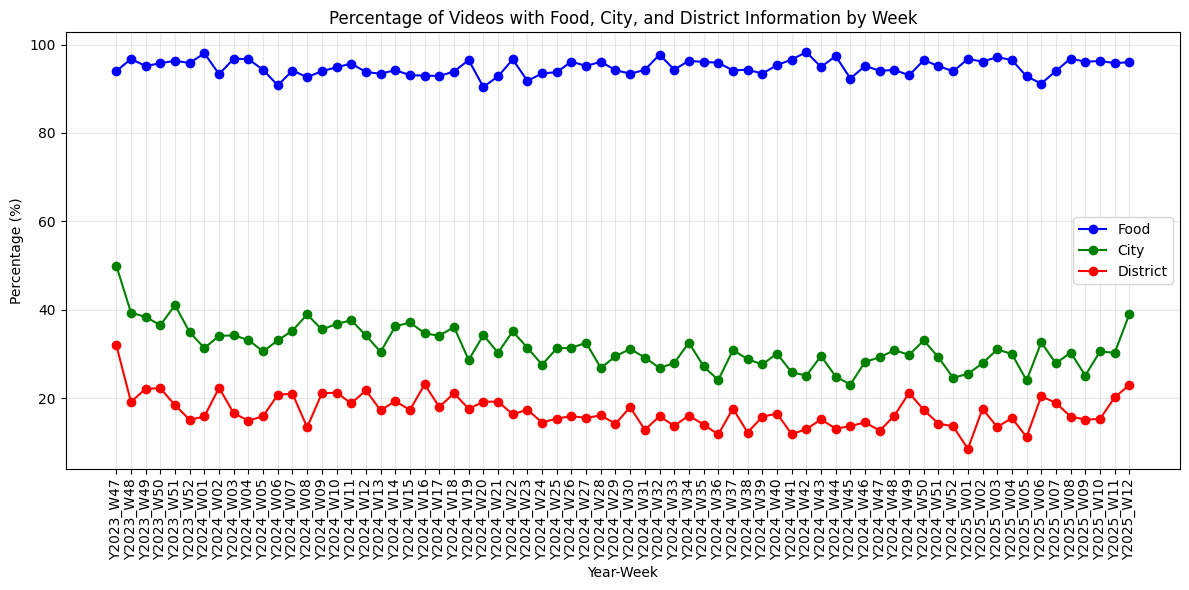

In [16]:
# Analyze food, city, and district data by week
import matplotlib.pyplot as plt

# Group by year_week and calculate basic statistics
weekly_stats = final_weekly_video_df.groupby('year_week').agg({
    'video.id': 'count',  # Total videos per week
    'foods': lambda x: x.notna().sum(),  # Videos with food info
    'city': lambda x: x.notna().sum(),  # Videos with city info
    'district': lambda x: x.notna().sum()  # Videos with district info
}).reset_index()

# Rename columns for clarity
weekly_stats.columns = ['year_week', 'total_videos', 'videos_with_food', 'videos_with_city', 'videos_with_district']

# Calculate percentages
weekly_stats['food_percentage'] = (weekly_stats['videos_with_food'] / weekly_stats['total_videos'] * 100).round(2)
weekly_stats['city_percentage'] = (weekly_stats['videos_with_city'] / weekly_stats['total_videos'] * 100).round(2)
weekly_stats['district_percentage'] = (weekly_stats['videos_with_district'] / weekly_stats['total_videos'] * 100).round(2)

# Show the statistics by week
display(weekly_stats.sort_values('year_week'))

# Calculate overall top foods, cities, and districts
all_foods = []
for food_list in final_weekly_video_df['foods'].dropna():
    if isinstance(food_list, list):
        all_foods.extend(food_list)

print("Top 20 foods across all weeks:")
display(pd.Series(all_foods).value_counts().head(20))

print("\nTop 10 cities across all weeks:")
display(final_weekly_video_df['city'].value_counts().head(10))

print("\nTop 10 districts across all weeks:")
display(final_weekly_video_df['district'].value_counts().head(10))

# Plot percentage of videos with food, city, and district information by week
plt.figure(figsize=(12, 6))
plt.plot(weekly_stats['year_week'], weekly_stats['food_percentage'], 'b-o', label='Food')
plt.plot(weekly_stats['year_week'], weekly_stats['city_percentage'], 'g-o', label='City')
plt.plot(weekly_stats['year_week'], weekly_stats['district_percentage'], 'r-o', label='District')
plt.title('Percentage of Videos with Food, City, and District Information by Week')
plt.xlabel('Year-Week')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
# # Save the weekly statistics to a Parquet file
# weekly_stats.to_parquet(
#     "../weekly_video_statistics.parquet", index=False)

## Lưu dataframe cuối cùng thành file Parquet

In [18]:
# Save the merged data to a Parquet file
# Top 20% weekly videos with food and location data
final_weekly_video_df.to_parquet(
    "./top_20_percent_weekly_videos_with_food_location.parquet", index=False)

In [20]:
pd.read_parquet(
    "./top_20_percent_weekly_videos_with_food_location.parquet").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14252 entries, 0 to 14251
Data columns (total 64 columns):
 #   Column                           Non-Null Count  Dtype                           
---  ------                           --------------  -----                           
 0   CategoryType                     14252 non-null  object                          
 1   author.downloadSetting           14252 non-null  object                          
 2   author.duetSetting               14252 non-null  object                          
 3   author.id                        14252 non-null  object                          
 4   author.nickname                  14252 non-null  object                          
 5   author.openFavorite              14252 non-null  object                          
 6   author.secUid                    14252 non-null  object                          
 7   author.signature                 14252 non-null  object                          
 8   author.stitchSet